# Cartpole

In [ ]:
import numpy as np
import time
import math

from pct.hierarchy import PCTHierarchy
from pct.functions import Subtract
from pct.functions import Sigmoid
from pct.functions import Constant
from pct.functions import Proportional
from pct.functions import WeightedSum
from pct.functions import PassOn
from pct.functions import Step

from pct.functions import Integration
from pct.functions import IntegrationDual
from pct.functions import OpenAIGym
from pct.functions import IndexedParameter
from pct.functions import GreaterThan

from pct.nodes import PCTNode
from pct.putils import FunctionsList

In [ ]:
cartpole_hierarchy = PCTHierarchy(levels=5, cols=1, name="cartpoleh", build=False)
cartpole_hierarchy.get_node(0, 0).name = 'cart_velocity_node'
cartpole_hierarchy.get_node(1, 0).name = 'cart_position_node'
cartpole_hierarchy.get_node(2, 0).name = 'pole_velocity_node'
cartpole_hierarchy.get_node(3, 0).name = 'pole_angle_node'
cartpole_hierarchy.get_node(4, 0).name = 'pole_position_node'

cartpole = OpenAIGym("CartPole-v1", name="CartPole-v1", render=True)
#cartpole = Constant([0.2,0.2,0.2,0.2,0.2+math.sin(0.2)], name="CartPole-v1")
cartpole_hierarchy.set_order("Down")


In [ ]:
# pole_position
cartpole_hierarchy.replace_function(level=4, col=0, collection="reference", function=Step(name="pole_position_reference", upper=2, lower=-2, delay=100, period=500), position=0)
cartpole_hierarchy.insert_function(level=4, col=0, collection="perception", function=IndexedParameter(index=4, name="pole_position", links=[cartpole]))
cartpole_hierarchy.insert_function(level=4, col=0, collection="output", function=Sigmoid(range=0.45, scale=2, name="pole_position_output"))
#cartpole_hierarchy.set_links( 'subtract4', 'pole_position_reference',  'pole_position')

# pole_angle
cartpole_hierarchy.replace_function(level=3, col=0, collection="reference", function=PassOn(name="pole_angle_reference", links=['pole_position_output']), position=0)
cartpole_hierarchy.insert_function(level=3, col=0, collection="perception", function=IndexedParameter(index=2, name="pole_angle", links=[cartpole]))
FunctionsList.getInstance().get_function("proportional3").set_name("pole_angle_output")
FunctionsList.getInstance().get_function("pole_angle_output").set_property('gain', 1.5)

# pole_velocity
cartpole_hierarchy.insert_function(level=2, col=0, collection="reference", function=PassOn(name="pole_velocity_reference", links=['pole_angle_output']))
cartpole_hierarchy.insert_function(level=2, col=0, collection="perception", function=IndexedParameter(index=3, name="pole_velocity", links=[cartpole]))
cartpole_hierarchy.replace_function(level=2, col=0, collection="output", function=PassOn(name="pole_velocity_output"), position=0)

# cart_position
cartpole_hierarchy.replace_function(level=1, col=0, collection="reference", function=IntegrationDual(name="cart_position_reference", gain=90, slow=100, links=['pole_velocity_output']), position=0)
cartpole_hierarchy.insert_function(level=1, col=0, collection="perception", function=IndexedParameter(index=0, name="cart_position", links=[cartpole]))
FunctionsList.getInstance().get_function("proportional1").set_name("cart_position_output")
FunctionsList.getInstance().get_function("cart_position_output").set_property('gain', 2)

# cart_velocity
cartpole_hierarchy.insert_function(level=0, col=0, collection="reference", function=PassOn(name="cart_velocity_reference", links=['cart_position_output']))
cartpole_hierarchy.insert_function(level=0, col=0, collection="perception", function=IndexedParameter(index=1, name="cart_velocity", links=[cartpole]))
cartpole_hierarchy.insert_function(level=0, col=0, collection="output", function=Integration(gain=-0.1, slow=4, name="force"))


In [ ]:
FunctionsList.getInstance().get_function("pole_position_reference").ctr


1

In [ ]:
greaterthan = GreaterThan(threshold=0, upper=1, lower=0, links='force')
cartpole_hierarchy.add_postprocessor(greaterthan)
cartpole_hierarchy.add_preprocessor(cartpole)
cartpole.add_link(greaterthan)

cartpole_hierarchy.build_links()
cartpole_hierarchy.add_links( 'cart_position_reference',  'cart_position')


In [ ]:
#cartpole_hierarchy.summary(build=False)

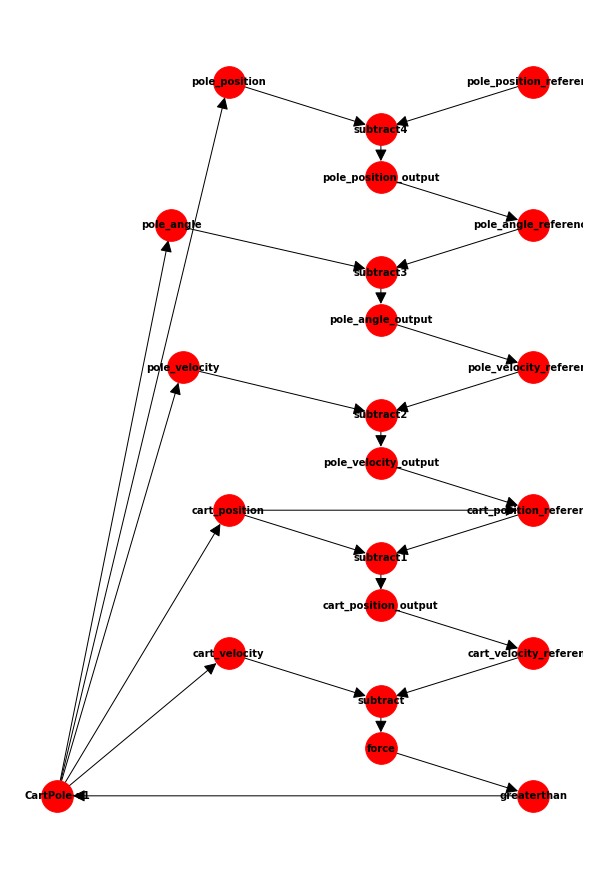

In [ ]:
cartpole_hierarchy.draw(font_size=10, figsize=(8,12), move={'CartPole-v1': [-0.075, 0] , 'pole_velocity': [-0.02, 0], 'pole_angle': [-0.025, 0]}, node_size=1000)


In [ ]:
cartpole_hierarchy.save("cartpole5-full.json")

In [ ]:
#cartpole_hierarchy.run(10, verbose=True)
cartpole_hierarchy.run(2000)
#cartpole_hierarchy.run(400)


500 -2
1000 2
1500 -2
2000 2


0

In [ ]:
cartpole.close()